# Generate test data

In [3]:
from EnzymePynetics.core.series import Series
from EnzymePynetics.core.species import Species
from EnzymePynetics.core.enzymekinetics import EnzymeKinetics
from EnzymePynetics.core.measurement import Measurement
from lmfit import Parameters, report_fit, minimize
from scipy.integrate import odeint
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt


%pwd


'/Users/max/code/EnzymePynetics'

## Irreversible MM

In [5]:
# Parameters of test reaction system
KM = 4
KCAT = 140
# k_inact = 0.1

init_sub = [0.5, 2, 4, 10, 15, 30]
ENZYME = 0.01

In [6]:
# Parameters for data generation
params = Parameters()
params.add("k_cat", value=KCAT, min=0.01 * KCAT, max=100 * KCAT)
params.add("K_m", value=KM, min=0.01 * KM, max=100 * KM)
# params.add("k_inact", value=0.12, min=0.0001, max=0.5)

In [7]:
# Kinetic model
def menten_irrev(w0: tuple, t, params):
    cS, cE, cP, cI = w0

    k_cat = params["k_cat"].value
    K_m = params["K_m"].value
    # k_inact = params['k_inact'].value

    dc_S = -k_cat * cE * cS / (K_m + cS)
    # dc_E = -cE * k_inact
    dc_E = 0
    dc_P = -dc_S
    dc_I = 0

    return (dc_S, dc_E, dc_P, dc_I)


# Integrator for MM rate equation
def g(t, w0, params):
    return odeint(menten_irrev, w0, t, args=(params,))

In [8]:
# Generate time-course data
time = np.arange(21)

substrate = np.empty((len(init_sub), len(time)))
for i, conc in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(conc, ENZYME, 0, 0), params=params).T[0]

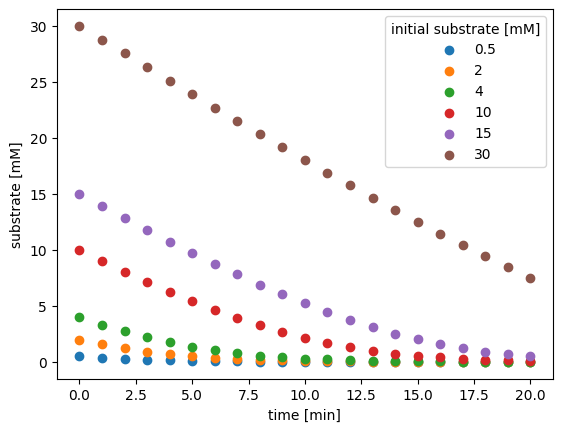

In [9]:
for conc, init_s in zip(substrate, init_sub):
    plt.scatter(time, conc, label=f"{init_s}")

plt.legend(title="initial substrate [mM]")
plt.ylabel("substrate [mM]")
plt.xlabel("time [min]")
plt.show()

In [10]:
add_substrate = lambda initial_conc, data: Species(
    species_type="substrate",
    conc_unit="mmol / l",
    initial_conc=initial_conc,
    data=[Series(values=data)],
)

add_enzyme = lambda initial_conc: Species(
    species_type="enzyme",
    conc_unit="mmol / l",
    initial_conc=initial_conc,
)

In [11]:
# Write data to json
measurements = []

for init_substrate, sub in zip(init_sub, substrate):
    substrate = add_substrate(initial_conc=init_substrate, data=sub.tolist())
    enzyme = add_enzyme(ENZYME)

    measurements.append(
        Measurement(
            time_unit="min",
            time=time.tolist(),
            temperature=37,
            temperature_unit="C",
            pH=7,
            species=[substrate, enzyme],
        )
    )

enzyme_kinetics = EnzymeKinetics(
    title="test irreversible MM", measurements=measurements
)

with open("irrev_MM_enzyme.json", "w") as f:
    f.write(enzyme_kinetics.json())

# With enzyme inactivation

In [105]:
# Parameters for data generation
params = Parameters()
params.add("k_cat", value=KCAT, min=0.01 * KCAT, max=100 * KCAT)
params.add("K_m", value=KM, min=0.01 * KM, max=100 * KM)
params.add("k_ei", value=k_ei, min=0, max=0.9)


# Kinetic model
def menten_irrev_inactivation(w0: tuple, t, params):
    cS, cE, cP, cI = w0

    k_cat = params["k_cat"].value
    K_m = params["K_m"].value
    k_ei = params["k_ei"].value

    dc_S = -k_cat * cE * cS / (K_m + cS)
    dc_E = -k_ei * cE
    dc_P = -dc_S
    dc_I = 0

    return (dc_S, dc_E, dc_P, dc_I)


# Integrator for MM rate equation
def g(t, w0, params):
    """
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    """
    w = odeint(menten_irrev_inactivation, w0, t, args=(params,))
    return w

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


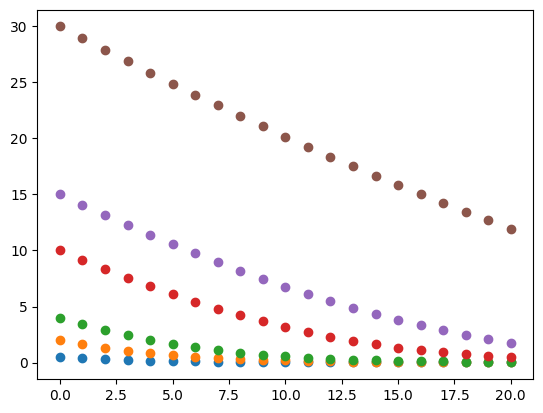

In [106]:
# Generate time-course data
time = np.arange(21)

substrate = np.empty((len(init_sub), len(time)))
print(substrate)
for i, init_s in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(init_s, enzyme, 0, 0), params=params).T[0]


for conc in substrate:
    plt.scatter(time, conc)
plt.show()

## Irreversible MM - integrated form

In [107]:
substrate.shape

(6, 21)

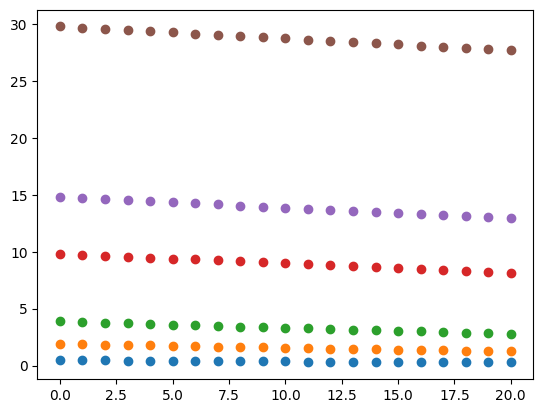

In [122]:
time = np.arange(23)

substrate = np.empty((len(init_sub), len(time)))
for i, conc in enumerate(init_sub):
    substrate[i] = g(t=time, w0=(conc, enzyme, 0, 0), params=params).T[0]

substrate = substrate[:, 2:]
time = time[:-2]
for conc in substrate:
    plt.scatter(time, conc)
plt.show()

In [125]:
measurements = []

for init_substrate, sub in zip(init_sub, substrate):
    species = Species(
        name="test substrate",
        reactant_type="substrate",
        conc_unit="mmole / l",
        initial_conc=init_substrate,
        data=[Series(values=sub.tolist())],
    )

    measurements.append(
        Measurement(
            time_unit="min",
            time=time.tolist(),
            enzyme_conc=enzyme,
            temperature=37,
            temperature_unit="C",
            pH=7,
            species=[species],
        )
    )

enzyme_kinetics = EnzymeKinetics(
    title="test irreversible MM", measurements=measurements
)

with open("irrev_MM_with_2min_delay.json", "w") as f:
    f.write(enzyme_kinetics.json())

In [123]:
# params
params = Parameters()
params.add("k_cat", value=10, min=0.01 * KCAT, max=100 * KCAT)
params.add("K_m", value=3, min=0.01 * KM, max=100 * KM)
params.add("t_0", value=0, min=-10, max=10)

In [111]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [8]:
def integrated_MM(
    cS,
    cE,
    cS0,
    params: Parameters,
    k_inactivation: float = None,
    enzyme_inactivation: bool = False,
) -> float:
    params = params.valuesdict()
    K_m = params["K_m"]
    k_cat = params["k_cat"]
    t_0 = params["t_0"]

    return -1 / (k_cat * cE) * (K_m * np.log(cS / cS0) + (cS - cS0)) + t_0


def residuals(params: Parameters, time, substrate, cE, init_sub):
    residuals = substrate * 0.0
    for init_S, cS in zip(init_sub, substrate):
        model = integrated_MM(cS, cE, init_S, params)

        residuals = model - time
    return residuals.flatten()


result = minimize(residuals, params, args=(time[:], substrate[:, :], enzyme, init_sub))
report_fit(result)

KeyError: 't_0'

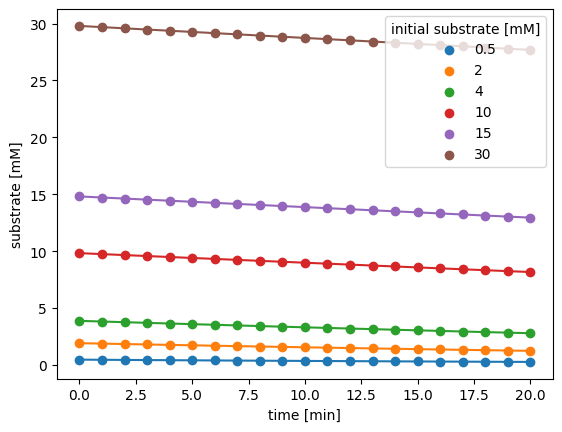

In [126]:
for s, s0 in zip(substrate, init_sub):
    plt.plot(integrated_MM(s, enzyme, s0, result.params), s)
    plt.scatter(time, s, label=f"{s0}")
    plt.legend(title="initial substrate [mM]")

    plt.ylabel("substrate [mM]")
    plt.xlabel("time [min]")

In [114]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

initial rates
[12.10978698  4.27491429] [0.03298971 0.03831777]


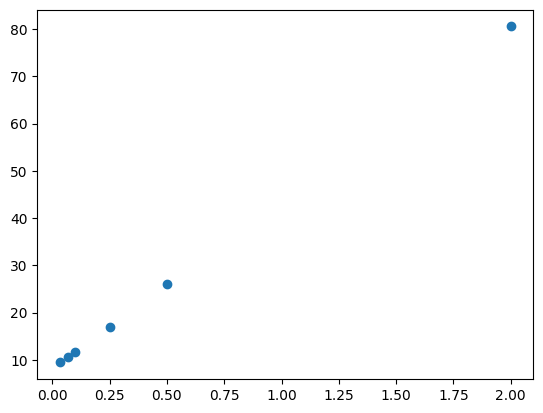

In [127]:
def MM(sub, k_cat, Km):
    return k_cat * enzyme * sub / (Km + sub)


# rates

slopes = [linregress([0, 1, 2], s[:3]).slope for s in substrate]
slopes


popt, pcov = curve_fit(MM, init_sub, np.absolute(slopes))

perr = np.sqrt(np.diag(pcov))
print("initial rates")
print(popt, perr)


plt.scatter(1 / np.array(init_sub), 1 / np.absolute(np.array(slopes)))
plt.show()

Text(0.5, 0, 'substrate [mM')

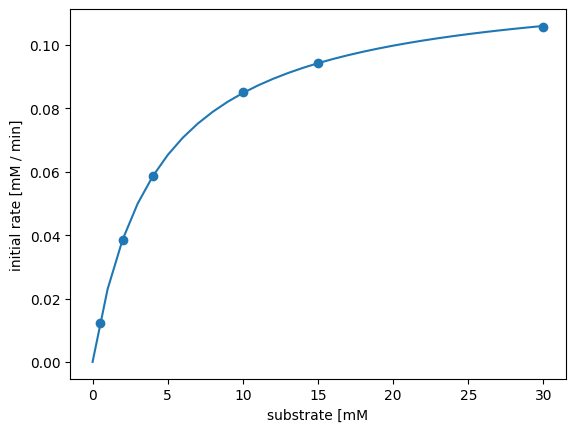

In [128]:
plt.plot(np.linspace(0, 30, 31), MM(np.array(np.linspace(0, 30, 31)), popt[0], popt[1]))
plt.scatter(init_sub, np.abs(slopes))
plt.ylabel("initial rate [mM / min]")
plt.xlabel("substrate [mM")

## Lineweaver Burk

In [117]:
lb = linregress(1 / np.array(init_sub), 1 / np.absolute(np.array(slopes)))

km = 1 / lb.intercept
k_cat = 1 / (km / lb.slope) / enzyme

print("lineweaver")
print(f"Km = {km}")
print(f"k_cat = {k_cat}")

lineweaver
Km = 2.0087738714490317
k_cat = 389.2918706386905


In [9]:
np.log(1)

0.0